# Example workflow to compare different climates for one glacier

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

import oggm
from oggm import cfg, utils, workflow, tasks
from oggm.core import massbalance, flowline, climate

# just for the graphics
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

cfg.initialize()


working_dir = utils.gettempdir(dirname='clim', reset=False)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# let's look at calendar years!!!
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1


2023-04-08 16:52:52: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-08 16:52:52: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-08 16:52:52: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-04-08 16:52:52: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2023-04-08 16:52:52: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.


In [2]:
#df = ['RGI60-11.01450'] 
# Let's take Artesonraju
df = ['RGI60-16.02444']

In [5]:
# preprocesseing 
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
#workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
#workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)

2023-04-08 16:53:37: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2023-04-08 16:53:37: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [9]:
# process cru and ERA5 data and get the climate data from the nearest gridpoint
from oggm.shop.cru import process_cru_data
cfg.PARAMS['baseline_climate'] = 'CRU'
workflow.execute_entity_task(process_cru_data, gdirs)
ds_cru = xr.open_dataset(gdirs[0].get_filepath('climate_historical'))
from oggm.shop.ecmwf import process_ecmwf_data
cfg.PARAMS['baseline_climate'] = 'ERA5'
# I gave that one a filesuffix to not overwrite the CRU dataset (they are now both in the gdirs folder !!!)
workflow.execute_entity_task(process_ecmwf_data, gdirs, dataset='ERA5', output_filesuffix = '_ERA5')
ds_era5 = xr.open_dataset(gdirs[0].get_filepath('climate_historical', filesuffix='_ERA5'))

2023-04-08 16:55:02: oggm.workflow: Execute entity tasks [process_cru_data] on 1 glaciers
2023-04-08 16:55:02: oggm.shop.cru: (RGI60-16.02444) process_cru_data
2023-04-08 16:55:03: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `ERA5`.
2023-04-08 16:55:03: oggm.workflow: Execute entity tasks [process_ecmwf_data] on 1 glaciers
2023-04-08 16:55:03: oggm.shop.ecmwf: (RGI60-16.02444) process_ecmwf_data_ERA5


`ref_hgt` is the mean altitude of the closest gridpoint from the applied climate dataset. The climate files in the gdir directory hence only represent the climate at the nearest gridpoint (not already downscaled to the glacier).

Let's check it out for CRU and ERA5

In [ ]:
gdirs[0]

In [10]:
ds_era5.ref_hgt

3805.6808868216976

In [11]:
ds_cru.ref_hgt

4553.0

Ok, we extracted the climate from the nearest gridpoint but they are on different altitudes. If we want to compare them, we need to downscale them to the same altitude.

Here we just use the AWS station height of Artesonraju, but it could also be the height gridpoints of the glacier:
-> if you just want to compare the two datasets without having an additional AWS station data, you can just use the 
 heighest gridpoint of the glacier for testing:
 
 `h= gdirs[0].get_inversion_flowline_hw()[0][0]`

In [13]:
# default temp. lapse rate: 
print(cfg.PARAMS['temp_default_gradient']) # K per metre

# station height
h = 4797
# just use the heightes gridpoint of the glacier for testing
#h = gdirs[0].get_inversion_flowline_hw()[0][0]
#print(h)

-0.0065


In [19]:
ds_cru.sel(time=slice(

<xarray.Dataset>
Dimensions:  (time: 1428)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2019-12-01
Data variables:
    prcp     (time) float32 ...
    temp     (time) float32 ...
Attributes:
    ref_hgt:         4553.0
    ref_pix_lon:     -77.58333333333333
    ref_pix_lat:     -8.916666666666657
    ref_pix_dis:     7078.7544712035115
    climate_source:  CRU TS4.04
    yr_0:            1901
    yr_1:            2019
    author:          OGGM
    author_info:     Open Global Glacier Model

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prcp     (month) float32 130.0 239.9 152.4 97.79 ... 34.26 81.84 101.0 93.73
    temp     (month) float32 5.578 5.141 5.494 5.251 ... 5.229 5.493 5.648 5.599

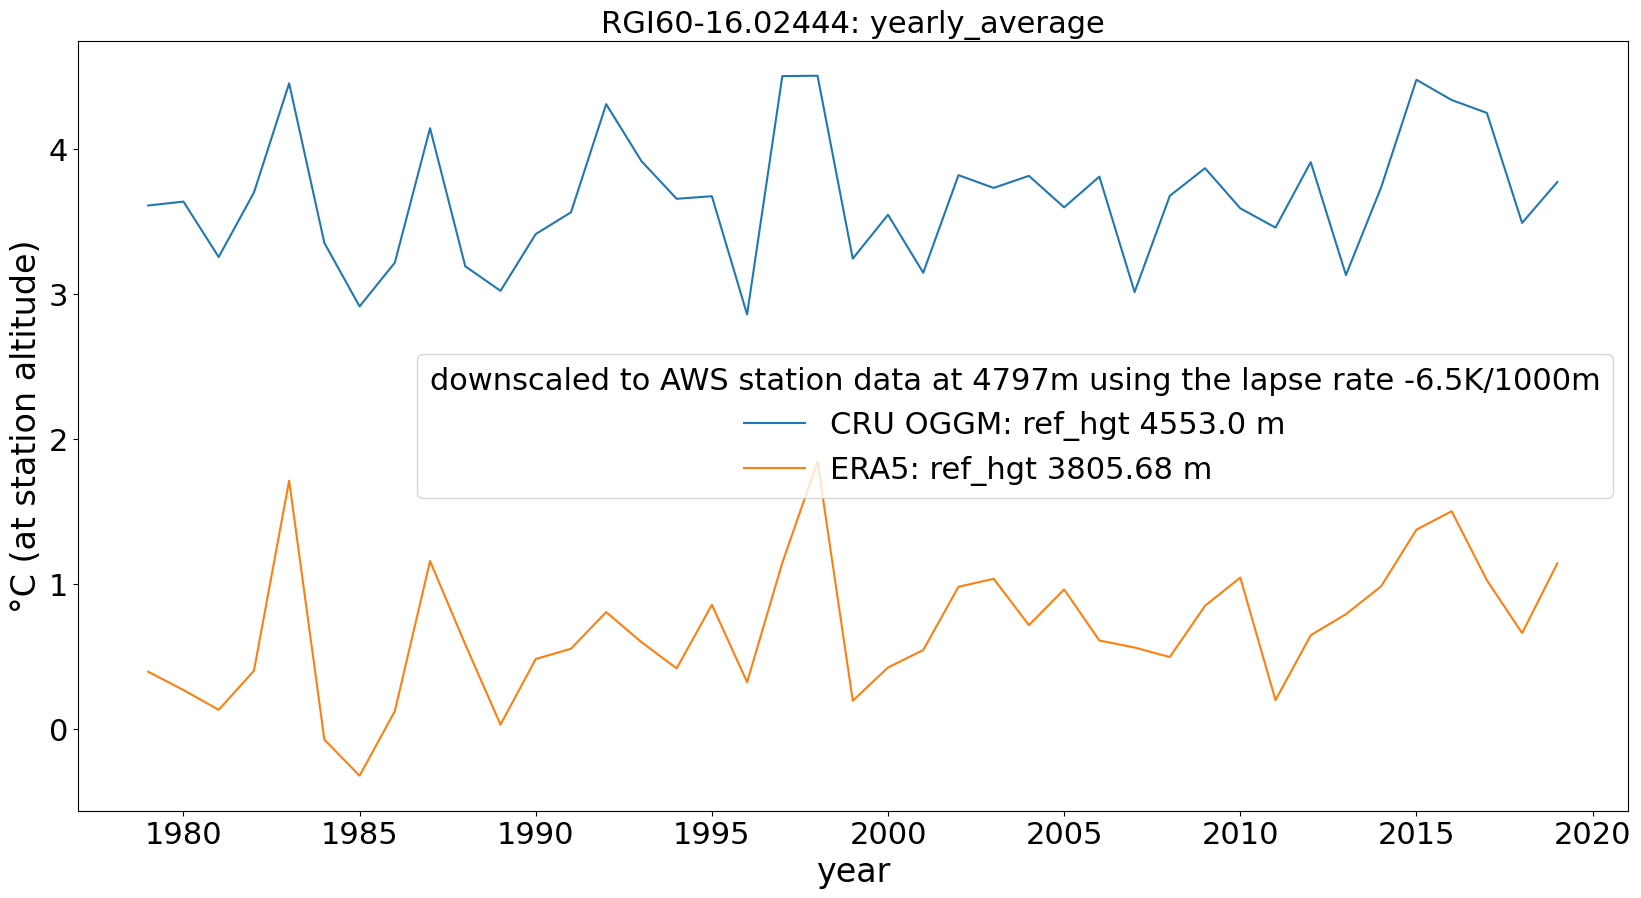

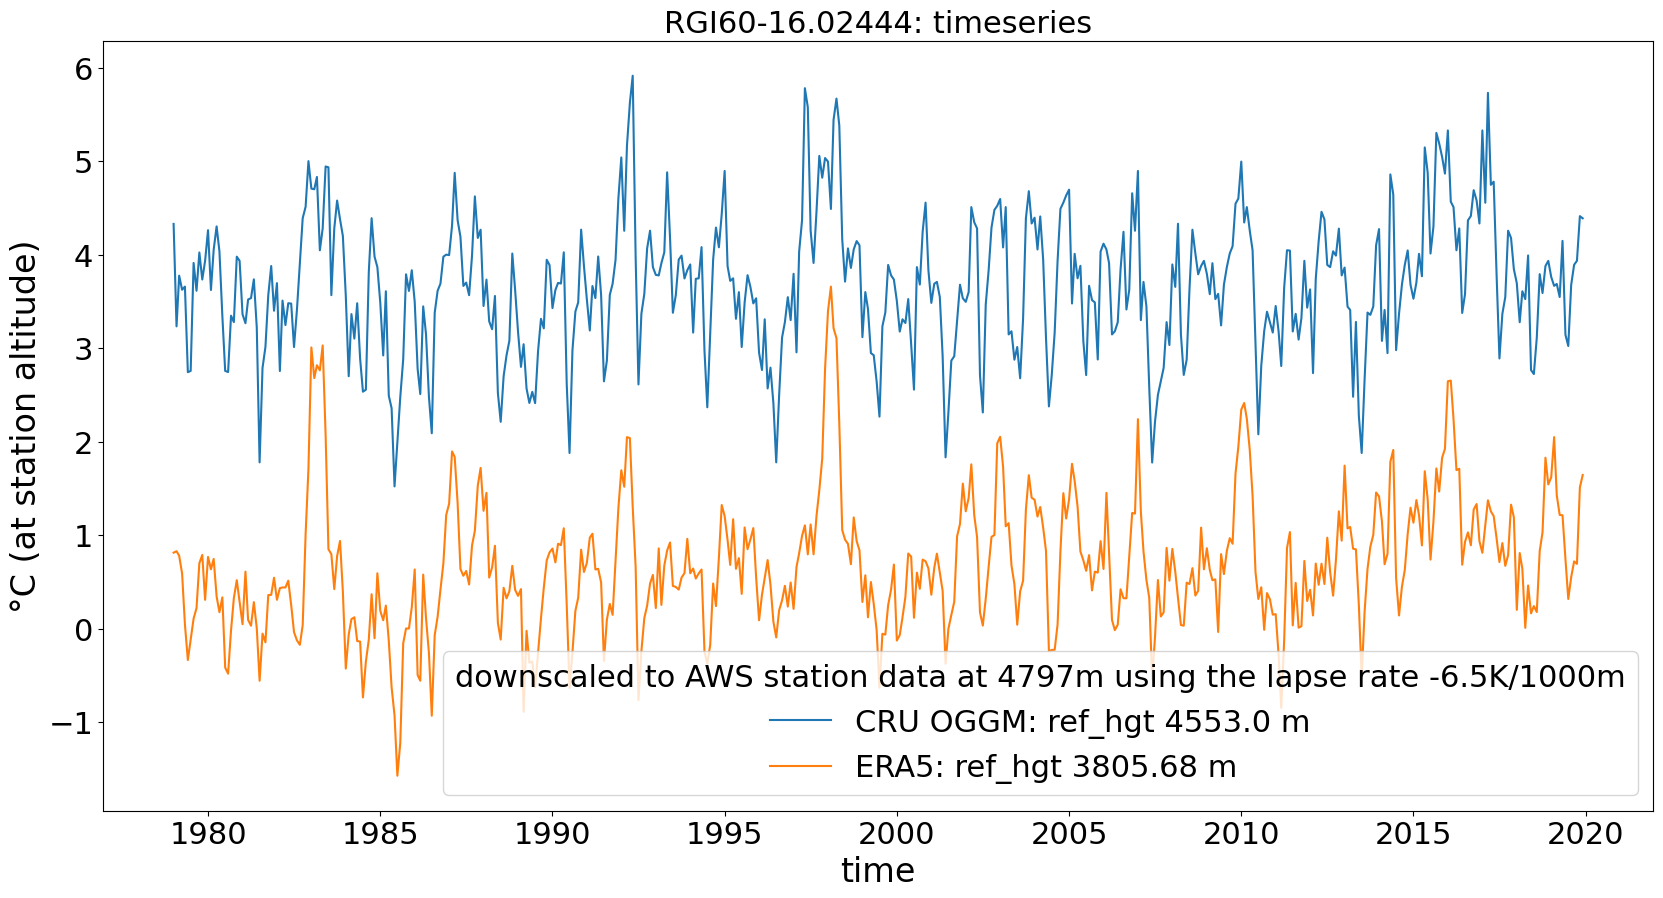

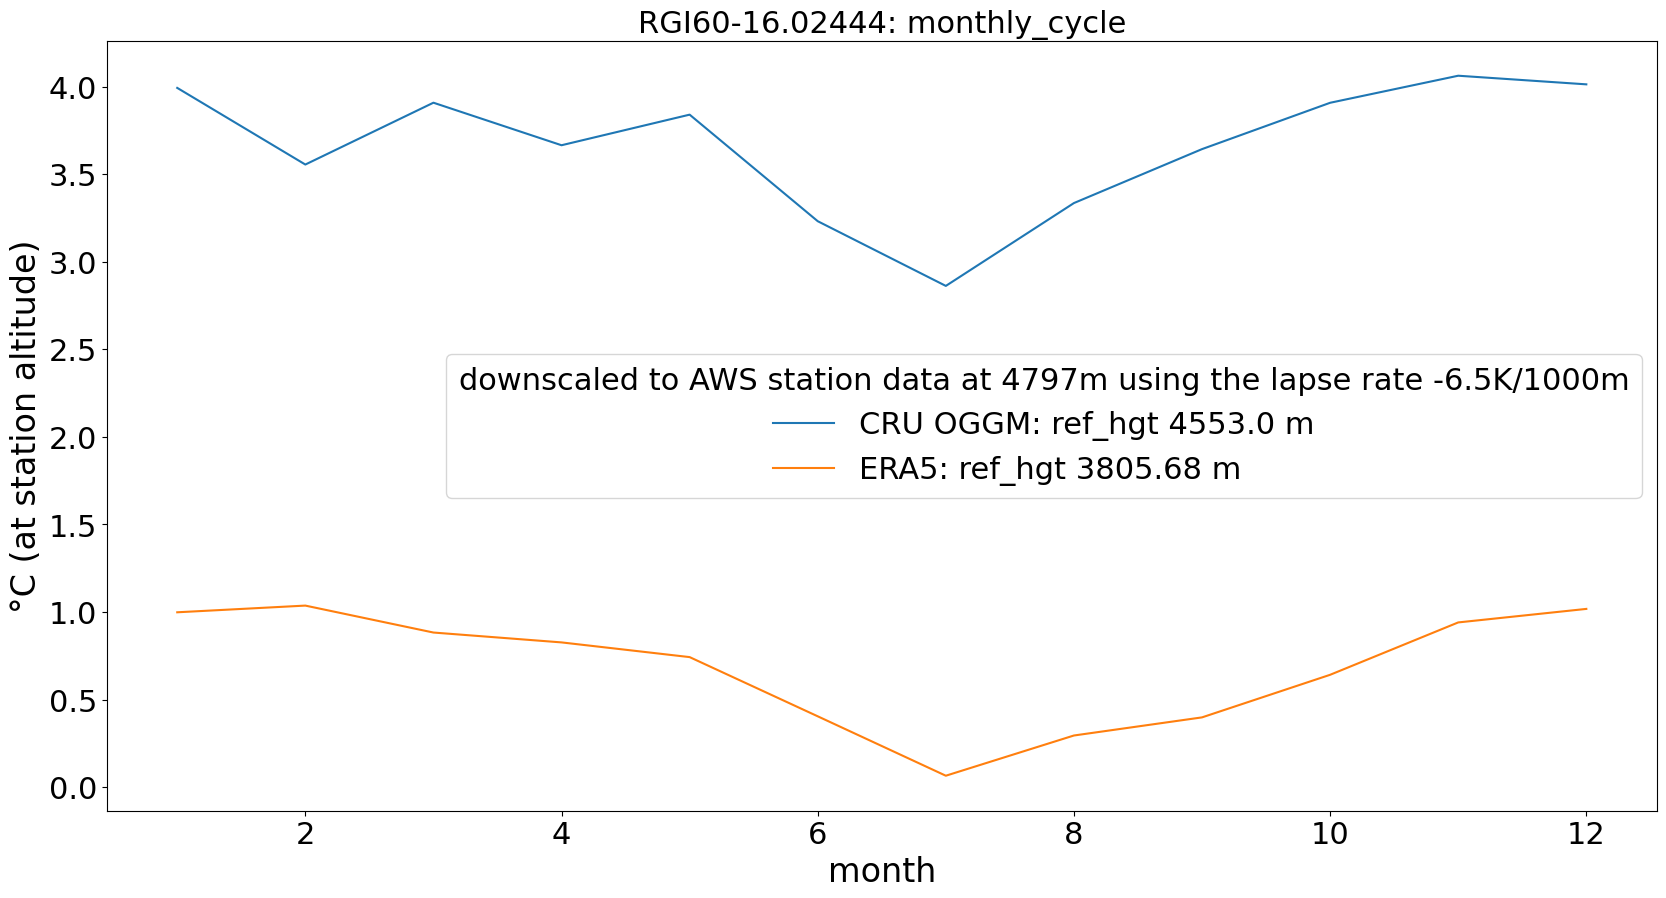

In [32]:
for opt in ['yearly_average','timeseries', 'monthly_cycle']:
    if opt=='yearly_average':
        # first make yearly mean temperatures
        ds_cru_temp_sel = ds_cru.groupby('time.year').mean().sel(year=np.arange(1979,2020,1)).temp
        ds_era5_temp_sel = ds_era5.groupby('time.year').mean().sel(year=np.arange(1979,2020,1)).temp
    elif opt=='timeseries':
        ds_cru_temp_sel = ds_cru.sel(time=slice('1979','2019')).temp
        ds_era5_temp_sel = ds_era5.sel(time=slice('1979','2019')).temp
    elif opt =='monthly_cycle':
        ds_cru_temp_sel = ds_cru.sel(time=slice('1979','2019')).groupby('time.month').mean().temp
        ds_era5_temp_sel = ds_era5.sel(time=slice('1979','2019')).groupby('time.month').mean().temp

    # then downscale them to the same alitutde h!
    ds_cru_temp_sel_h =  ds_cru_temp_sel + (h-ds_cru.ref_hgt)* cfg.PARAMS['temp_default_gradient'] 
    ds_era5_temp_sel_h = ds_era5_temp_sel + (h-ds_era5.ref_hgt)* cfg.PARAMS['temp_default_gradient'] 

    plt.figure(figsize=(20,10))
    plt.title(f'{gdirs[0].rgi_id}: {opt}')
    if opt=='yearly_average':
        plt.plot(ds_cru_temp_sel_h.year, ds_cru_temp_sel_h, label=f'CRU OGGM: ref_hgt {ds_cru.ref_hgt} m')
        plt.plot(ds_era5_temp_sel_h.year, ds_era5_temp_sel_h, label= f'ERA5: ref_hgt {ds_era5.ref_hgt.round(2)} m')
        plt.xlabel('year')
    elif opt=='timeseries':
        plt.plot(ds_cru_temp_sel_h.time, ds_cru_temp_sel_h, label=f'CRU OGGM: ref_hgt {ds_cru.ref_hgt} m')
        plt.plot(ds_era5_temp_sel_h.time, ds_era5_temp_sel_h, label= f'ERA5: ref_hgt {ds_era5.ref_hgt.round(2)} m')
        plt.xlabel('time')
    elif opt =='monthly_cycle':
        plt.plot(ds_cru_temp_sel_h.month, ds_cru_temp_sel_h, label=f'CRU OGGM: ref_hgt {ds_cru.ref_hgt} m')
        plt.plot(ds_era5_temp_sel_h.month, ds_era5_temp_sel_h, label= f'ERA5: ref_hgt {ds_era5.ref_hgt.round(2)} m')
        plt.xlabel('month')
    #plt.plot(ds_cru_ts4_05.groupby('time.year').mean().year, ds_cru_ts4_05.groupby('time.year').mean().tmp, label='uncorrected CRU TS4.05')
    plt.legend(title=f'downscaled to AWS station data at {h}m using the lapse rate -6.5K/1000m')
    plt.ylabel('°C (at station altitude)')


### If you would like to compare it to TS4_05

In [16]:
ds_cru_ts4_05 = xr.open_dataset('/home/lilianschuster/Schreibtisch/PhD/climate_comparison/cru_ts4.05.2011.2020.tmp.dat.nc').sel(lon = gdirs[0].cenlon, lat = gdirs[0].cenlat, method='nearest')

In [49]:
ds_cru_ts4_05

<xarray.Dataset>
Dimensions:  (time: 120)
Coordinates:
    lon      float32 -77.75
    lat      float32 -8.75
  * time     (time) datetime64[ns] 2011-01-16 2011-02-15 ... 2020-12-16
Data variables:
    tmp      (time) float32 ...
    stn      (time) float64 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.05 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2103051243. Data generated from:tmp.2103041709.dtb
    history:      Fri  5 Mar 13:25:53 GMT 2021 : User harry : Program makegri...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

---> would need to downscale this, but don't know the altitude! If it is 870m  lower than the station altitude it perfectly matches! 

Text(0.5, 0, 'year')

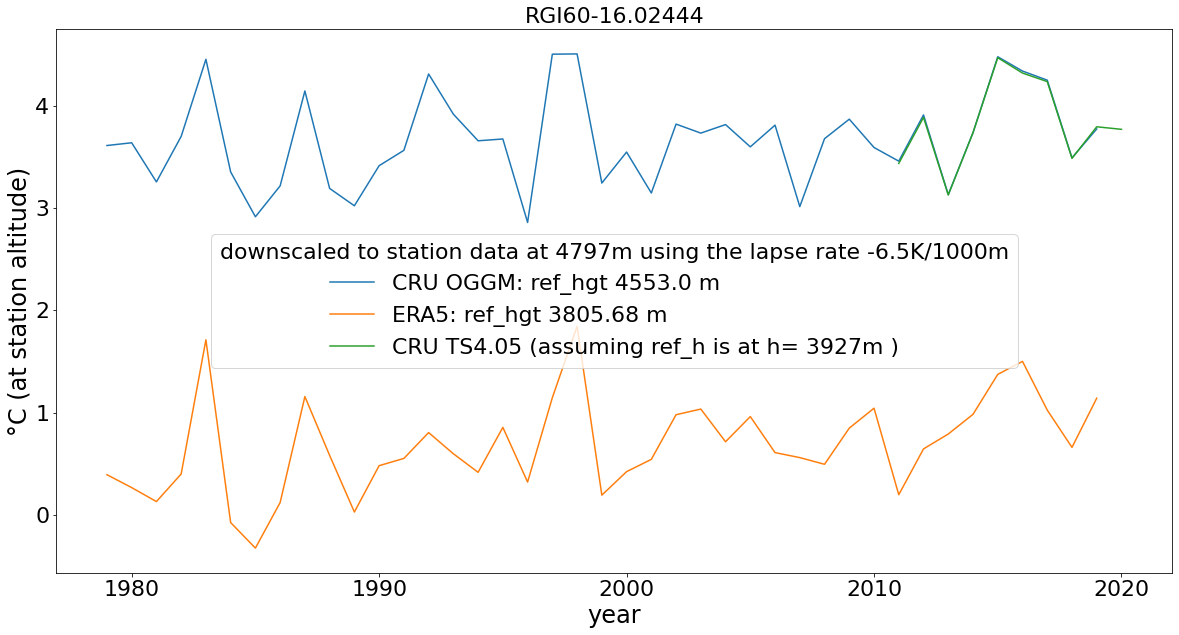

In [48]:
delta_h = 870 
plt.figure(figsize=(20,10))
plt.title(gdirs[0].rgi_id)
plt.plot(ds_cru_temp_sel_h.year, ds_cru_temp_sel_h, label=f'CRU OGGM: ref_hgt {ds_cru.ref_hgt} m')
plt.plot(ds_era5_temp_sel_h.year, ds_era5_temp_sel_h, label= f'ERA5: ref_hgt {ds_era5.ref_hgt.round(2)} m')

plt.plot(ds_cru_ts4_05.groupby('time.year').mean().year, ds_cru_ts4_05.groupby('time.year').mean().tmp + delta_h* cfg.PARAMS['temp_default_gradient'] ,
         label=f'CRU TS4.05 (assuming ref_h is at h= {h-delta_h}m )')
plt.legend(title=f'downscaled to station data at {h}m using the lapse rate -6.5K/1000m')
plt.ylabel('°C (at station altitude)')
plt.xlabel('year')